In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA

In [2]:
covid_df = pd.read_csv('owid_covid_data.csv')

# Removing columns 
high_missing_cols = covid_df.columns[covid_df.isnull().mean() > 0.90]
medium_missing_cols = covid_df.columns[(covid_df.isnull().mean() > 0.50) & (covid_df.isnull().mean() <= 0.90)]

covid_df_clean = covid_df.drop(columns=high_missing_cols).drop(columns=medium_missing_cols)


covid_df_clean['case_fatality_rate'] = covid_df_clean['total_deaths'] / covid_df_clean['total_cases']
covid_df_clean['log_total_cases'] = np.log1p(covid_df_clean['total_cases'])
covid_df_clean['log_total_deaths'] = np.log1p(covid_df_clean['total_deaths'])

### Classification
---

#### Create a Response Variable

In [3]:
covid_df_clean = covid_df_clean[covid_df_clean['case_fatality_rate'].notnull()]  # remove rows with missing CFR

covid_df_clean['pandemic_response_score'] = pd.qcut(
    covid_df_clean['case_fatality_rate'], 
    q=3, 
    labels=["Good", "Moderate", "Poor"]
)


c:\Users\antho\OneDrive\Documents\COLLEGE\UH\4-Semester-4\COSC-3337\datascience-covid-project\3337-covid-report\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


#### Data Splitting

In [4]:
socioeconomic_features = [
    'population_density',
    'median_age',
    'aged_65_older',
    'aged_70_older',
    'gdp_per_capita',
    'cardiovasc_death_rate',
    'diabetes_prevalence',
    'female_smokers',
    'male_smokers',
    'hospital_beds_per_thousand',
    'life_expectancy',
    'human_development_index',
    'population'
]

X = covid_df_clean[socioeconomic_features]
y = covid_df_clean['pandemic_response_score']


X = X.dropna()
y = y.loc[X.index]

# Identify rows with infinity values
inf_rows = np.isinf(X).any(axis=1)

# Remove rows with infinity values
X = X[~inf_rows]
y = y[~inf_rows]

# Verify that rows with infinity are removed
np.isinf(X).sum()

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)



scaler = StandardScaler()
X_tr_norm = scaler.fit_transform(X_tr)
X_tst_norm = scaler.transform(X_tst) 

#### Decision Trees

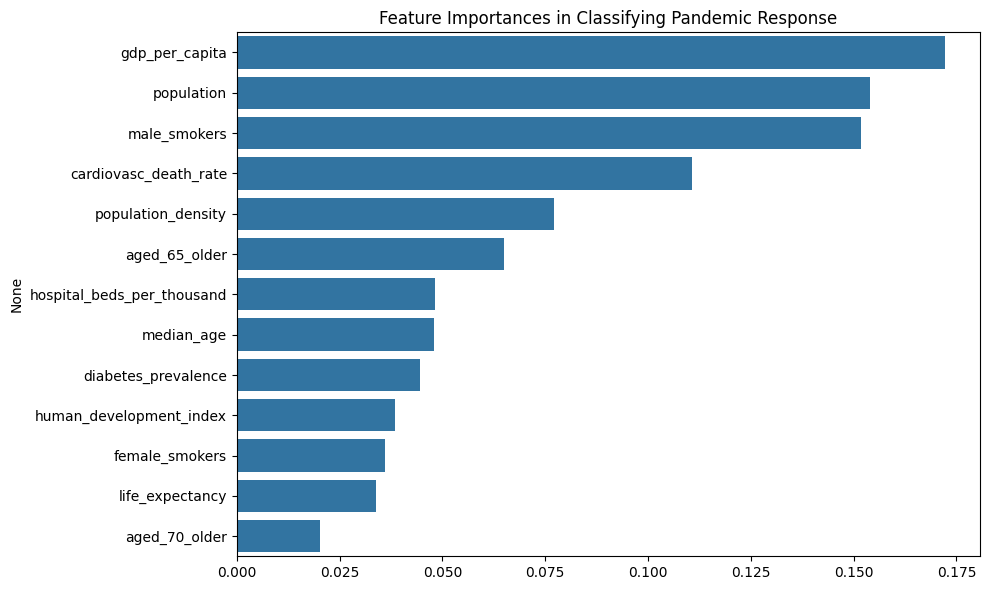

Depth: 21
Leaves: 124


In [5]:

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_tr, y_tr)  # No need to scale for Decision Trees
y_pred_dt = dt_model.predict(X_tst)

features = X.columns

importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Feature Importances in Classifying Pandemic Response")
plt.tight_layout()
plt.show()


print(f"Depth: {dt_model.get_depth()}")
print(f"Leaves: {dt_model.get_n_leaves()}")



##### Pruning Tree

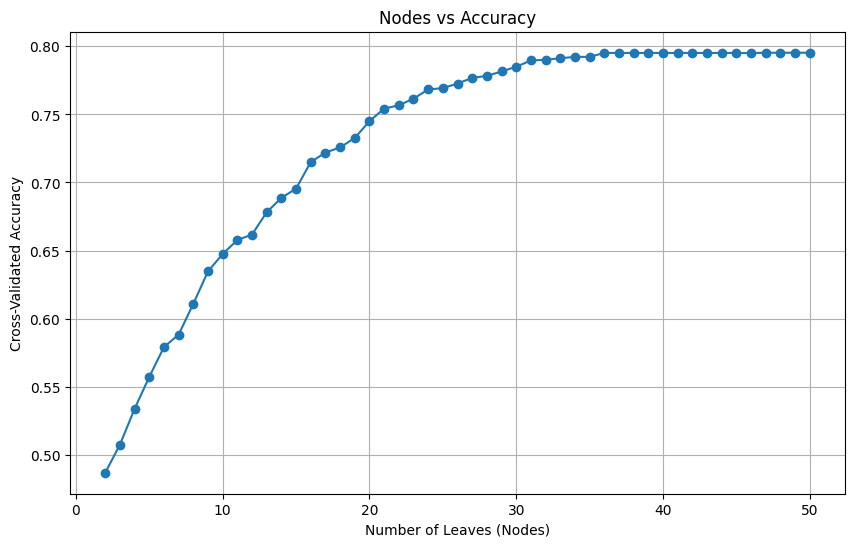

In [6]:
leaf_nodes = []
accuracies = []

# Try different max_leaf_nodes values 
for max_leaves in range(2, 51):
    dt_model = DecisionTreeClassifier(max_leaf_nodes=max_leaves, random_state=42)
    score = cross_val_score(dt_model, X_tr, y_tr, cv=10).mean()
    leaf_nodes.append(max_leaves)
    accuracies.append(score)

# Plot the number of leaves vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(leaf_nodes, accuracies, marker='o')
plt.xlabel("Number of Leaves (Nodes)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Nodes vs Accuracy")
plt.grid(True)
plt.show()

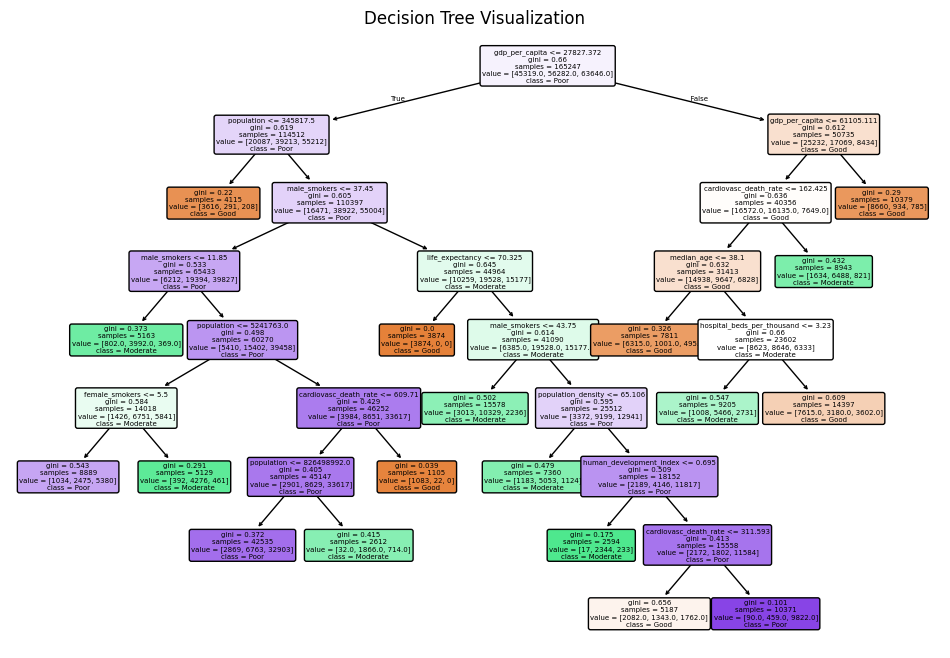

In [7]:
dt_model = DecisionTreeClassifier(max_leaf_nodes=18, random_state=42)
dt_model.fit(X_tr, y_tr)  # No need to scale for Decision Trees
y_pred_dt = dt_model.predict(X_tst)


plt.figure(figsize=(12, 8))
plot_tree(dt_model, 
          feature_names=X_tr.columns,  
          class_names=["Good", "Moderate", "Poor"],   
          filled=True,               
          rounded=True,              
          fontsize=5)               
plt.title("Decision Tree Visualization")
plt.show()

#### KNN

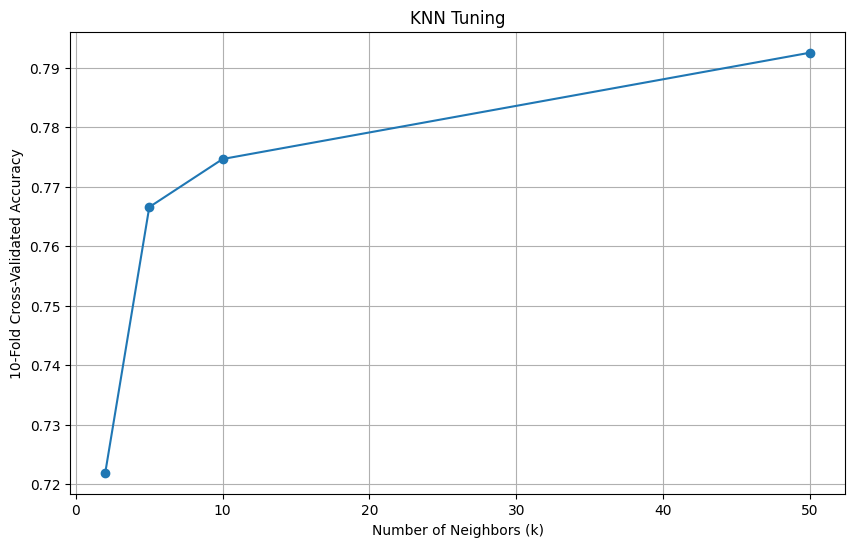

In [8]:
k_vals = [2, 5, 10, 50]
cv_scores =[]

for k in k_vals:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_tr_norm, y_tr, cv=10)
    cv_scores.append(scores.mean())


# Plot k vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_vals, cv_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("10-Fold Cross-Validated Accuracy")
plt.title("KNN Tuning")
plt.grid(True)
plt.show()



In [9]:
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_tr_norm, y_tr)  # Use scaled data for KNN
y_pred_knn = knn_model.predict(X_tst_norm)

#### SVM

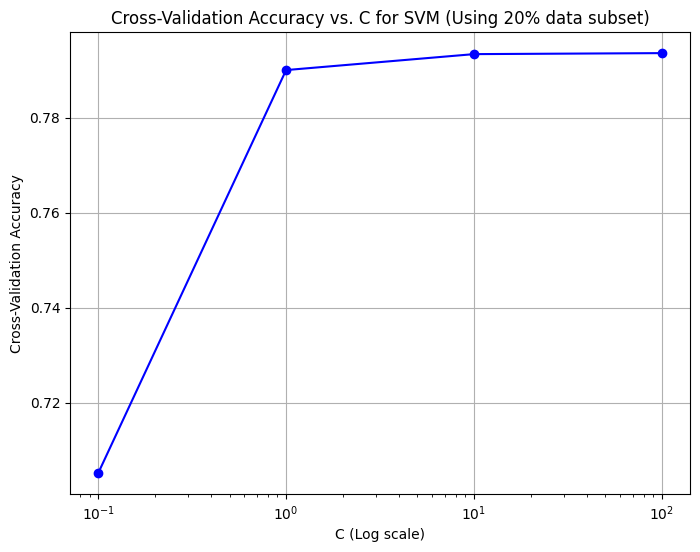

In [16]:
# Subsample the training data 
sample_frac = 0.2
X_sub, y_sub = X_tr_norm[:int(len(X_tr_norm) * sample_frac)], y_tr[:int(len(y_tr) * sample_frac)]

c_values = [0.1, 1, 10, 100]  

cv_scores = []

# Perform 5-fold cross-validation for each C value
for C in c_values:
    svm_model = SVC(C=C, random_state=42)
    scores = cross_val_score(svm_model, X_sub, y_sub, cv=5, scoring='accuracy')  
    cv_scores.append(scores.mean())  

# Plot C values vs. Accuracy
plt.figure(figsize=(8, 6))
plt.plot(c_values, cv_scores, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Use logarithmic scale for the x-axis to visualize the range better
plt.xlabel('C (Log scale)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy vs. C for SVM (Using 20% data subset)')
plt.grid(True)
plt.show()



In [13]:
svm_model = SVC(C=1,random_state=42)
svm_model.fit(X_tr_norm, y_tr)  # Use scaled data for SVM
y_pred_svm = svm_model.predict(X_tst_norm)

### Compare Models
---

#### Decision Tree

In [84]:
# Evaluate Decision Tree Model
print("Decision Tree Accuracy:", accuracy_score(y_tst, y_pred_dt))
print(classification_report(y_tst, y_pred_dt))
print(confusion_matrix(y_tst, y_pred_dt))



Decision Tree Accuracy: 0.7284808288148722
              precision    recall  f1-score   support

        Good       0.70      0.73      0.72     11272
    Moderate       0.70      0.71      0.70     14198
        Poor       0.77      0.75      0.76     15842

    accuracy                           0.73     41312
   macro avg       0.73      0.73      0.73     41312
weighted avg       0.73      0.73      0.73     41312

[[ 8243  2014  1015]
 [ 1751 10013  2434]
 [ 1786  2217 11839]]


#### KNN 

In [91]:
# Evaluate KNN Model
print("KNN Accuracy:", accuracy_score(y_tst, y_pred_knn))
print(classification_report(y_tst, y_pred_knn))
print(confusion_matrix(y_tst, y_pred_knn))


KNN Accuracy: 0.7761909372579395
              precision    recall  f1-score   support

        Good       0.73      0.77      0.75     11272
    Moderate       0.73      0.80      0.77     14198
        Poor       0.87      0.76      0.81     15842

    accuracy                           0.78     41312
   macro avg       0.78      0.78      0.77     41312
weighted avg       0.78      0.78      0.78     41312

[[ 8710  1756   806]
 [ 1752 11387  1059]
 [ 1515  2358 11969]]


#### SVM

In [15]:
# Evaluate SVM Model
print("SVM Accuracy:", accuracy_score(y_tst, y_pred_svm))
print(classification_report(y_tst, y_pred_svm))
print(confusion_matrix(y_tst, y_pred_svm))


SVM Accuracy: 0.7888022850503486
              precision    recall  f1-score   support

        Good       0.70      0.87      0.78     11272
    Moderate       0.77      0.79      0.78     14198
        Poor       0.91      0.73      0.81     15842

    accuracy                           0.79     41312
   macro avg       0.79      0.80      0.79     41312
weighted avg       0.80      0.79      0.79     41312

[[ 9796  1077   399]
 [ 2288 11148   762]
 [ 1912  2287 11643]]
